In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

In [2]:
def load_json(fname):
    with open(fname) as f:
        df = pd.DataFrame(json.load(f))
    return df

In [3]:
def summary_plot(df, title="", pattern="results/weights_{}/summary.csv"):
    if isinstance(df, str):
        df = pd.read_csv(pattern.format(df))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    df = df[df["stage"] <= 2]
    for stage in df["stage"].unique():
        filtered = df[df["stage"] == stage]
        axs[0].plot(
            filtered["period"], filtered["validation_loss"],
            label="stage " + str(stage))
        axs[1].plot(
            filtered["period"], filtered["training_loss_mean"],
            label="stage " + str(stage))
    axs[0].set_title("Validation Loss")
    axs[0].legend()
    axs[1].set_title("Training Loss")
    axs[1].legend()
    fig.suptitle(title)

In [4]:
def compare(o1, o2="results/baseline.json", name1="L2O", name2="Adam", title=""):

    df1 = load_json(o1)
    df2 = load_json(o2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(np.log(df1["loss"]), label=name1)
    axs[0].plot(np.log(df2["loss"]), label=name2)
    axs[0].legend()
    axs[0].set_title("Log training loss per epoch")

    axs[1].plot(df1["val_loss"], label=name1)
    axs[1].plot(df2["val_loss"], label=name2)
    axs[1].legend()
    axs[1].set_title("Validation loss per epoch")
    fig.suptitle(title)

In [5]:
def compare_set(periods, ax, title):
    base = "results/weights_imitation_1t_64b/stage_2n/period_{}.json"
    for period, color in zip(periods, plt.cm.jet(np.linspace(0, 1, len(periods)))):
        try:
            df = load_json(base.format(period))
            ax.plot(np.log(df["loss"]), label="Period {}".format(period), color=color)
        except FileNotFoundError:
            pass
    adam = load_json("results/baseline.json")
    ax.plot(np.log(adam["loss"]), label="Adam")
    ax.legend()
    ax.set_title(title)

# Preliminary Results

## Setup

#### L2O
- All experiments are run using RNNProp.

#### Training
- 2-layer MLP on MNIST with 20 hidden units in the middle layer; sigmoid activation
- Curriculum Learning is used, with unroll length of $32 * 2^i$ at 0-indexed stage $i$
- Default annealing schedule for imitation learning is $exp(-0.1n)$ at 0-indexed period $n$
- Since the code becomes unstable due to memory pressure at the stage 3 (training unroll=256, validation unroll=512), I only ran the first 3 training stages (32/64, 64/128, 128/256), and used the last L2O.

#### Validation
- Performed as specified by curriculum learning
- No imitation loss

#### Evaluation
- 2-layer conv stack on MNIST using ReLU activation
- Evaluated for 25 epochs (After 25 epochs, Adam and most L2Os reach a training loss of essentially zero)

## Batch Size
Larger batch sizes (64 vs 32) during training lead to more training stability and better overall performance.

Curiously, we can observe that the validation loss for the batch size 64 case continues decreasing for longer than Adam, and reaches a minimum where the training loss is still higher than Adam.

I have two ideas that may explain this:

1. The optimizer is trained on MLP, so it only knows how to overfit MLP. This is supported by the fact that the RNNProp training loss is higher than the Adam training loss at epoch 10, where the validation loss reaches its minimum.
2. RNNProp's learning rate is limited by passing the output through a tanh activation and multiplying by a learning rate parameter (set to 0.1). This is likely related to its less steep but much more consistent improvement over time, which also may have the side effect of reducing overfitting.



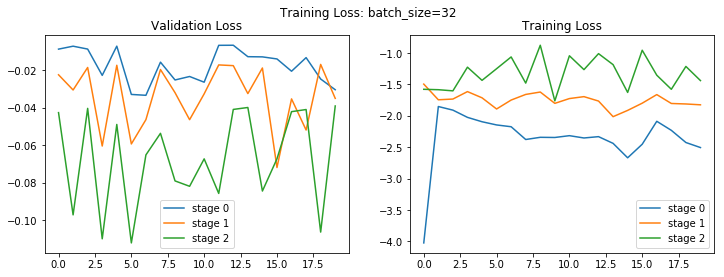

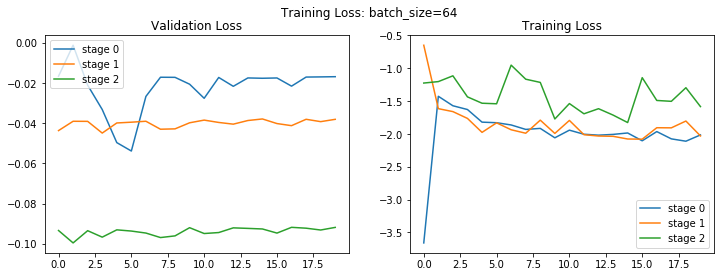

In [8]:
summary_plot("imitation_1t_32b", title="Training Loss: batch_size=32")
summary_plot("imitation_1t_64b", title="Training Loss: batch_size=64")

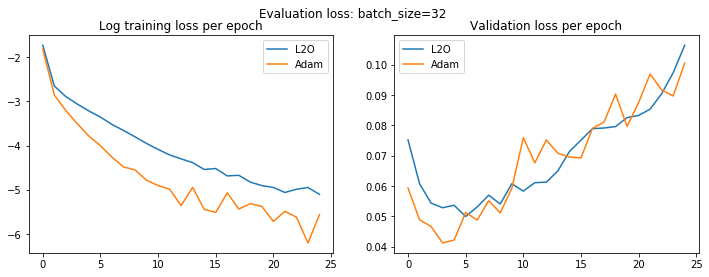

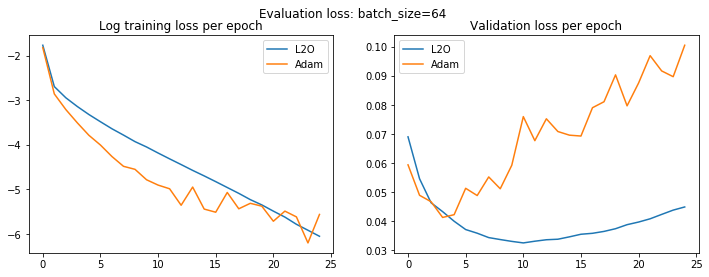

In [9]:
compare("results/weights_imitation_1t_32b/stage_2/period_19.json", title="Evaluation loss: batch_size=32")
compare("results/weights_imitation_1t_64b/stage_2/period_19.json", title="Evaluation loss: batch_size=64")

## Imitation Learning

### Number of Teachers

With no imitation learning, the optimizer appears to get "stuck", and the training appears to be quite unstable. Similarly with 2 teachers (loss is the mean of the two), the optimizer stops working after 1 epoch; the training is also much more unstable than with 1 teacher.


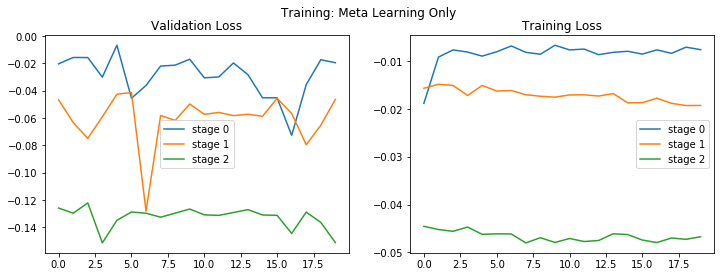

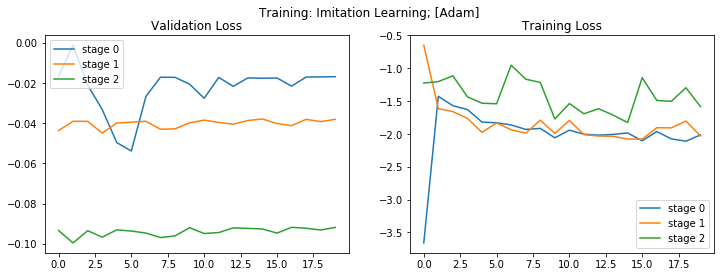

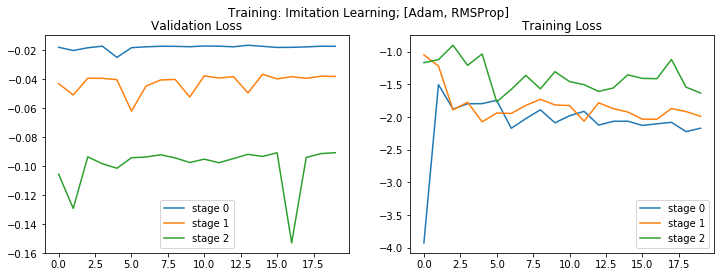

In [10]:
summary_plot("meta_64b", title="Training: Meta Learning Only")
summary_plot("imitation_1t_64b", title="Training: Imitation Learning; [Adam]")
summary_plot("imitation_2t_64b", title="Training: Imitation Learning; [Adam, RMSProp]")

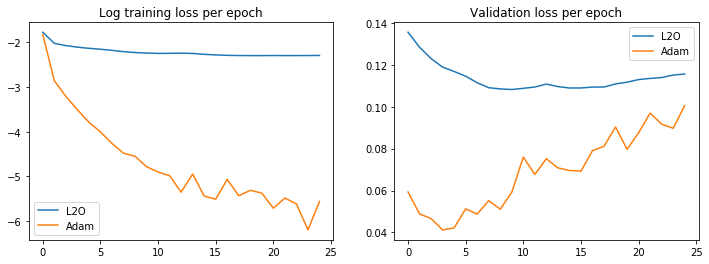

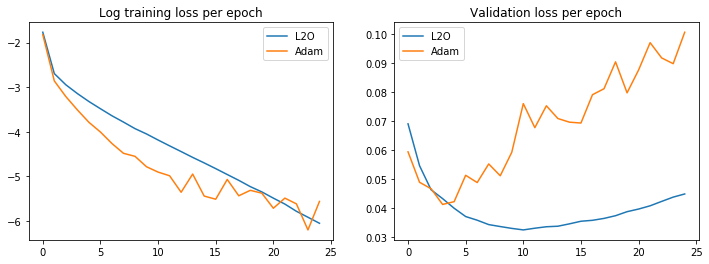

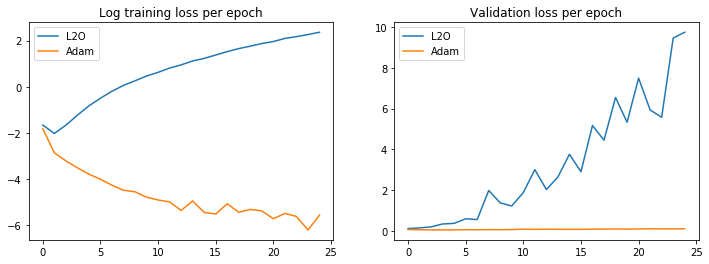

In [11]:
compare("results/weights_meta_64b/stage_2/period_19.json")
compare("results/weights_imitation_1t_64b/stage_2/period_19.json")
compare("results/weights_imitation_2t_64b/stage_2/period_19.json")

### Annealing

Here, I experimented with a gentler annealing schedule. It appears that the gentler schedule leads to more training instability and poorer performance.

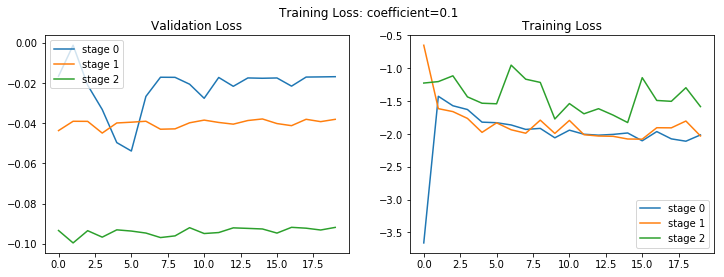

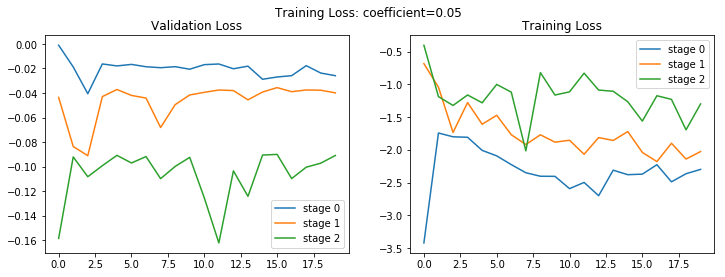

In [12]:
summary_plot("imitation_1t_64b", title="Training Loss: coefficient=0.1")
summary_plot("imitation_1t_64b_gradual", title="Training Loss: coefficient=0.05")

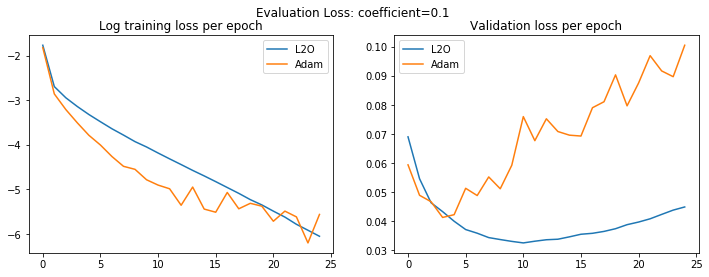

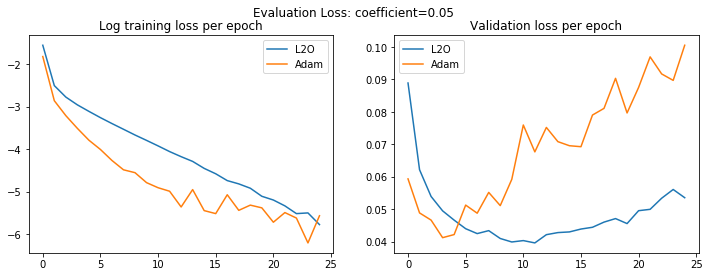

In [13]:
compare("results/weights_imitation_1t_64b/stage_2/period_19.json", title="Evaluation Loss: coefficient=0.1")
compare("results/weights_imitation_1t_64b_gradual/stage_2/period_19.json", title="Evaluation Loss: coefficient=0.05")

### Mean imitation loss vs Maximum imitation loss

Using maximum loss between the two teachers (i.e. training imitation with multiple experts in a minimax way), the performance actually improves; the optimizer is able to improve the loss for 6 epochs (training and validation trajectories were only 5 epochs long).


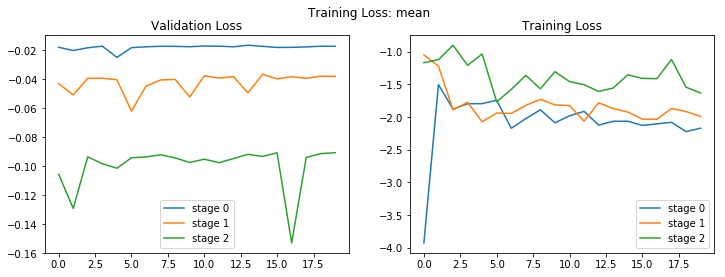

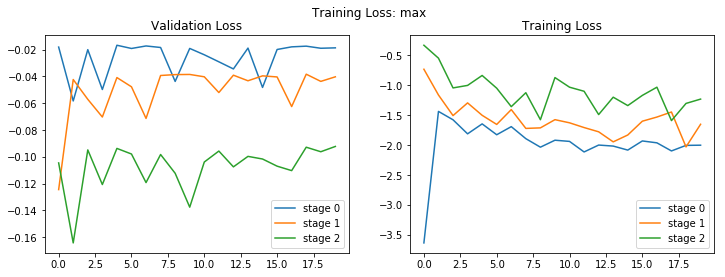

In [14]:
summary_plot("imitation_2t_64b", title="Training Loss: mean")
summary_plot("imitation_2t_64b_max", title="Training Loss: max")

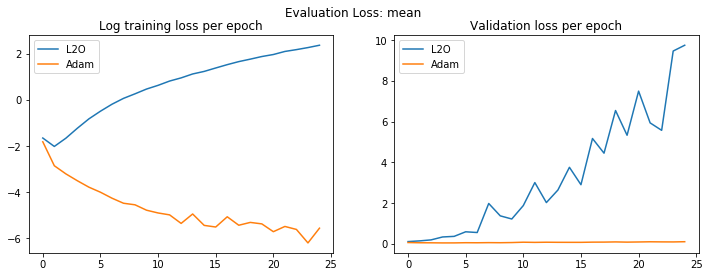

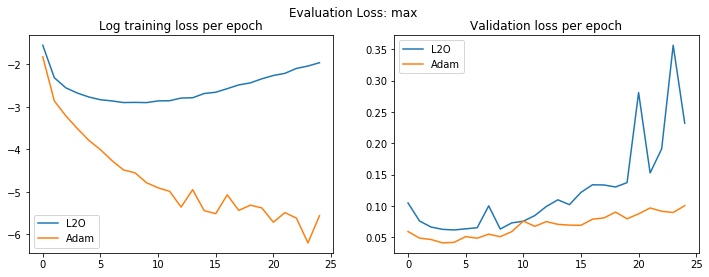

In [15]:
compare("results/weights_imitation_2t_64b/stage_2/period_19.json", title="Evaluation Loss: mean")
compare("results/weights_imitation_2t_64b_max/stage_2/period_19.json", title="Evaluation Loss: max")

### Analysis

I think that imitation learning can be viewed by considering the space of all RNNProp L2Os and the space of all hand-crafted optimizers. Adam and RMSprop can be viewed as being local minima in the space of all hand-crafted optimizers, which is a subspace of the space of all RNNProp L2Os.

By using imitation learning with 1 teacher, we are essentially initializing the optimizer at a local minimum in the space of all hand-crafted optimizers. Then, as the probability of choosing imitation learning is gradually annealed, we allow our L2O to move further away from this starting point in the space of all RNNProp L2Os. Since we know that the starting point is a "good" optimizer that performs reasonably, the local minimum starting from that point in the larger space should also perform reasonably.

When we instead choose 2 teachers, we initialize the L2O at the midpoint of two local minima; there is no guarantee that this midpoint corresponds to a 'good' local minimum in the space of all RNNProp L2Os.

This is supported by these observations:

1. L2O training in general is very sensitive to initialization.

    Especially with the Scale L2O, many internal weights must be initialized precisely, or the loss explodes or converges to a bad value most of the time, though not always. Most often, this occurs when Dense layer weights on the output are initialized as a glorot uniform or other random intialization instead of a constant zero.

    This indicates that a "good" intialization is critical for good L2O training.

2. Imitation Learning training is extremely sensitive to hyperparameters.

    In RNNProp, the beta_1 and beta_2 first and second moment exponential-moving-average decay constants are fixed the same way as in Adam. I observed that if these constants are not the same between the L2O and Adam teacher, imitation learning performance is extremely bad, often converging on a local minimum where the optimizee would be trained to output a constant \[0.1...0.1\] value, where the labels 0-9 are all predicted with confidence 0.1.
    
    Similarly, in experimenting with the Scale L2O, I found that if it was not extremely easy (through the "shortcut connection" described in appendix B.1) for the learner to imitate the teacher, the learner would get stuck on extremely high imitation loss (>10^10) and eventually converge to the same \[0.1...0.1\] optimizee output when imitation learning was annealed away.

    Furthermore, with imitation learning and a single teacher, I never experienced loss explosion or convergence at high values. This indicates that imitation learning is acting as a "good" initialization.

3. These trends persist even when evaluating on the same network as training.

    In the first plot below, the 2-teacher, mean loss RNNProp L2O is evaluated on the same network as the one used during training. While the loss does not explode, it does stop decreasing after a few epochs. This indicates that the specified local minimum is in fact a "bad" local minimum.

    In the second plot, we can see that evaluation performance (again on the same network as used in training) performs better 1 period back, which suggests that significant overfitting occurs between period 1 and 2. This further suggests that the local minimum the L2O has found is associated with higher overfitting than the L2O with a single teacher.


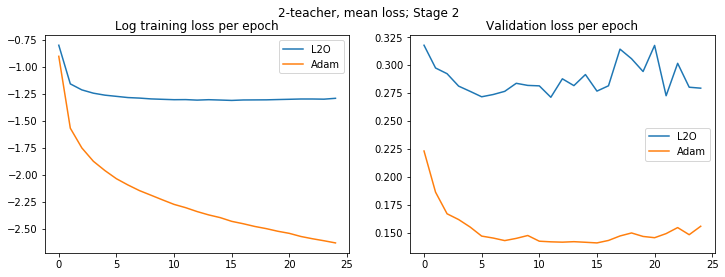

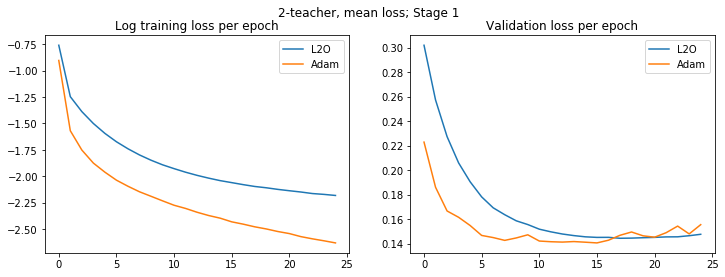

In [16]:
compare("results/weights_imitation_2t_64b/stage_2/period_19_simple_mlp.json", "results/baseline_simple_mlp.json", title="2-teacher, mean loss; Stage 2")
compare("results/weights_imitation_1t_64b/stage_2/period_19_simple_mlp.json", "results/baseline_simple_mlp.json", title="2-teacher, mean loss; Stage 1")

## Problems

### Instability

I believe that the biggest problem by far is the inherent instability of the L2O problem due to the extremely long trajectories demanded especially during evaluation.

- The evaluation and validation loss are erratic and unstable (top left).
- Validation loss does not appear to have any relationship with evaluation loss (top right).
- Within the same stage, the L2O frequently fluctuates between good (bottom right) and bad (bottom left) generalizers.


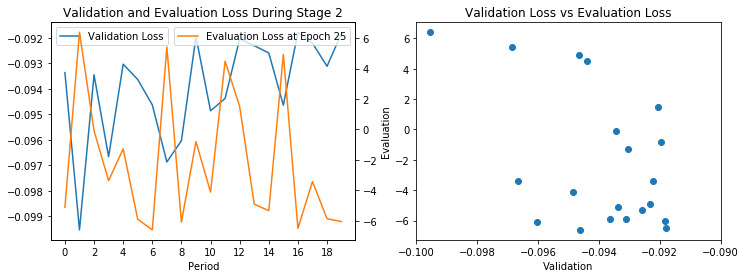

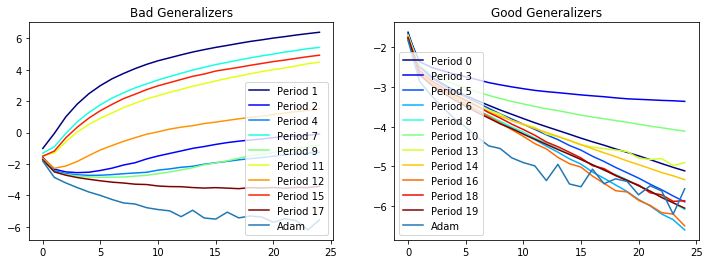

In [6]:
base = "results/weights_imitation_1t_64b/stage_2n/period_{}.json"
df  = pd.read_csv("results/weights_imitation_1t_64b/summary.csv")
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df = df[df["stage"] == 2]
df['at_epoch_end'] = [load_json(base.format(period))["loss"][24] for period in df["period"]]
axs[0].plot(df["period"], df["validation_loss"], label="Validation Loss")
axs_twin = axs[0].twinx()
axs_twin.plot(
    df["period"], np.log(df['at_epoch_end']), label="Evaluation Loss at Epoch 25",
    color="tab:orange")
axs[0].legend()
axs[0].set_title("Validation and Evaluation Loss During Stage 2")
axs[0].set_xticks(np.arange(0, 20, 2))
axs[0].set_xlabel("Period")
axs_twin.legend()
axs[1].scatter(df["validation_loss"], np.log(df["at_epoch_end"]))
axs[1].set_title("Validation Loss vs Evaluation Loss")
axs[1].set_xlabel("Validation")
axs[1].set_ylabel("Evaluation")
axs[1].set_xlim(-0.100, -0.090)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_set([1, 2, 4, 7, 9, 11, 12, 15, 17], axs[0], "Bad Generalizers")
compare_set([0, 3, 5, 6, 8, 10, 13, 14, 16, 18, 19], axs[1], "Good Generalizers")


## Possible Solutions

### Imitation Optimizer
I use Adam as the meta-optimizer to train the L2O. Since Adam uses a scaled momentum-based update, and the gradient magnitudes for imitation-loss and meta-loss are likely very different most of the time, I instead tried using two different Adam instances to maintain a separate first and second moment for imitation learning.

This appears to make the training process more stable, and improves the final evaluation results. I observed that my implementation of imitation learning loss has higher magnitudes than curriculum learning, and likely much larger gradients as well. Since the probability of choosing imitation learning becomes annealed to zero, these steps likely caused the optimizer to "jump" out of the desired local minimum.

Since this was one of the first things I tried, the separate imitation optimizer is used on all experiments above.


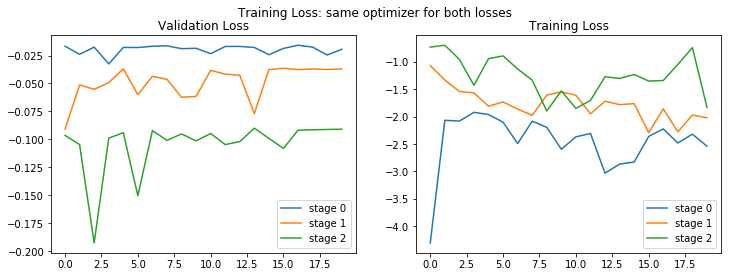

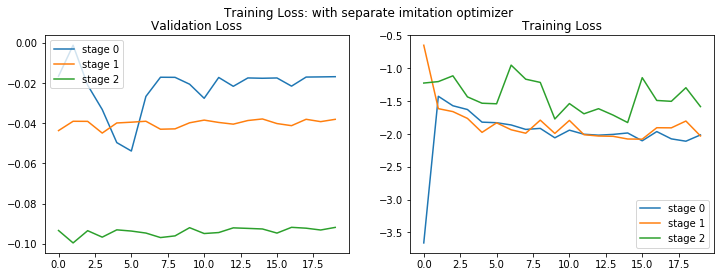

In [9]:
summary_plot("imitation_1t_64b_sameopt", title="Training Loss: same optimizer for both losses")
summary_plot("imitation_1t_64b", title="Training Loss: with separate imitation optimizer")

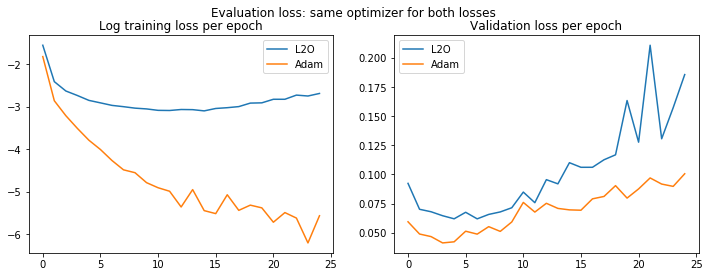

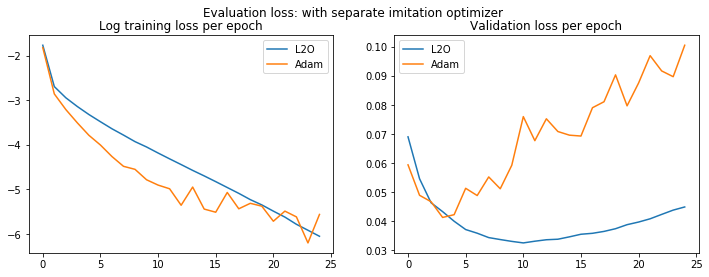

In [7]:
compare("results/weights_imitation_1t_64b_sameopt/stage_2/period_19.json", title="Evaluation loss: same optimizer for both losses")
compare("results/weights_imitation_1t_64b/stage_2/period_19.json", title="Evaluation loss: with separate imitation optimizer")

### Imitation Optimizer with Shared Momentum

One of the weaknesses of the dual-optimizer method is that having two separate momentum states may increase instability as imitation learning becomes more rare -- the momentum may be "off" due to the parameter state moving a large distance from when the momentum was last updated.

The two optimizer system could thus be extended to use different second moments for scaling, but the same momentum state. 

This would be accomplished by passing the second optimizer a reference to the primary optimizer, and having the second optimizer ```get_slot()``` from the first optimizer when updating or referencing the momentum.